# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2

# **Load Dataset**

In [2]:
# Membaca dataset
df = pd.read_csv('penyakitpencernaan.csv')
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,Gastroenteritis,sunken_eyes,dehydration,diarrhoea,NaN,NaN
1,Gastroenteritis,vomiting,dehydration,diarrhoea,NaN,NaN
2,Gastroenteritis,vomiting,sunken_eyes,dehydration,diarrhoea,NaN
3,Gastroenteritis,vomiting,sunken_eyes,dehydration,NaN,NaN
4,Gastroenteritis,vomiting,sunken_eyes,diarrhoea,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Disease    19 non-null     object
 1   Symptom_1  19 non-null     object
 2   Symptom_2  19 non-null     object
 3   Symptom_3  19 non-null     object
 4   Symptom_4  15 non-null     object
 5   Symptom_5  14 non-null     object
dtypes: object(6)
memory usage: 1.0+ KB


In [4]:
# Mengecek Duplikat
df.duplicated().sum()

np.int64(2)

In [5]:
# Mengecek Missing Value
df.isnull().sum()

,0
Disease,0
Symptom_1,0
Symptom_2,0
Symptom_3,0
Symptom_4,4
Symptom_5,5


In [6]:
# Mengisi nilai NaN dengan 'none'
df.fillna('none', inplace=True)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
0,Gastroenteritis,sunken_eyes,dehydration,diarrhoea,none,none
1,Gastroenteritis,vomiting,dehydration,diarrhoea,none,none
2,Gastroenteritis,vomiting,sunken_eyes,dehydration,diarrhoea,none
3,Gastroenteritis,vomiting,sunken_eyes,dehydration,none,none
4,Gastroenteritis,vomiting,sunken_eyes,diarrhoea,none,none


In [7]:
# Mengambil semua gejala unik dari setiap kolom (kecuali kolom pertama) pada df
# lalu menghapus nilai "none" dan mengonversinya menjadi list dan menampilkannya
all_symptoms = set()
for col in df.columns[1:]:
    all_symptoms.update(df[col].unique())
all_symptoms.discard("none")
all_symptoms = list(all_symptoms)
all_symptoms

[' acidity',
 ' sunken_eyes',
 ' diarrhoea',
 ' cough',
 ' internal_itching',
 ' passage_of_gases',
 ' stomach_pain',
 ' chest_pain',
 ' abdominal_pain',
 ' dehydration',
 ' indigestion',
 ' vomiting',
 ' loss_of_appetite',
 ' ulcers_on_tongue']

In [8]:
# Membersihkan spasi pada awal kalimat gejala pada DataFrame
# lalu mengumpulkan semua gejala unik (kecuali 'none') dari semua kolom kecuali kolom pertama dan menampilkannya
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
all_symptoms = set()
for col in df.columns[1:]:
    all_symptoms.update(df[col].unique())
all_symptoms.discard("none")
all_symptoms = list(all_symptoms)
all_symptoms

<ipython-input-8-ef624d254315>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


['dehydration',
 'abdominal_pain',
 'sunken_eyes',
 'stomach_pain',
 'diarrhoea',
 'cough',
 'internal_itching',
 'passage_of_gases',
 'vomiting',
 'acidity',
 'chest_pain',
 'loss_of_appetite',
 'indigestion',
 'ulcers_on_tongue']

In [9]:
# Mengurutkan gejala sesuai dengan abjad
all_symptoms = sorted(all_symptoms)
all_symptoms

['abdominal_pain',
 'acidity',
 'chest_pain',
 'cough',
 'dehydration',
 'diarrhoea',
 'indigestion',
 'internal_itching',
 'loss_of_appetite',
 'passage_of_gases',
 'stomach_pain',
 'sunken_eyes',
 'ulcers_on_tongue',
 'vomiting']

In [10]:
# Menampilkan jumlah gejala
jumlah_symptoms = len(all_symptoms)
print(f"Jumlah gejala unik: {jumlah_symptoms}")

Jumlah gejala unik: 14


In [11]:
def augment_data(df, num_augmented_samples=300):
    augmented_data = []
    diseases = df["Disease"].unique()
    for disease in diseases:
        disease_rows = df[df["Disease"] == disease]
        disease_symptoms = set()
        for _, row in disease_rows.iterrows():
            for col in df.columns[1:]:
                symptom = row[col].strip()
                if symptom != "none":
                    disease_symptoms.add(symptom)
        disease_symptoms = list(disease_symptoms - {"none"})
        for _ in range(num_augmented_samples):
            num_symptoms = random.randint(1, min(len(disease_symptoms), 5))
            selected_symptoms = random.sample(disease_symptoms, num_symptoms)
            if disease == "Gastroenteritis" and "dehydration" in disease_symptoms:
                if "dehydration" not in selected_symptoms:
                    selected_symptoms[0] = "dehydration"
            new_row = {"Disease": disease}
            for i in range(1, 6):
                new_row[f"Symptom_{i}"] = "none"
            for i, symptom in enumerate(selected_symptoms, 1):
                if i <= 5:
                    new_row[f"Symptom_{i}"] = symptom
            augmented_data.append(new_row)
    return pd.DataFrame(augmented_data)

# Augmentasi dan gabungkan dataset
df_augmented = augment_data(df, num_augmented_samples=300)
df_combined = pd.concat([df, df_augmented], ignore_index=True)
df_combined.fillna("none", inplace=True)

In [12]:
#Encode gejala (One-Hot Encoding)
def symptoms_to_vector(row):
    symptom_vector = [0] * len(all_symptoms)
    for col in df.columns[1:]:
        symptom = row[col].strip()  # Pastikan spasi dihapus
        if symptom != "none" and symptom in all_symptoms:
            symptom_vector[all_symptoms.index(symptom)] = 1
    return symptom_vector

symptom_vectors = df_combined.apply(symptoms_to_vector, axis=1, result_type="expand")
symptom_vectors.columns = all_symptoms

In [13]:
# Encode label penyakit
le = LabelEncoder()
df_combined["Disease"] = le.fit_transform(df_combined["Disease"])
df_encoded = pd.concat([df_combined["Disease"], symptom_vectors], axis=1)

In [14]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919 entries, 0 to 918
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Disease           919 non-null    int64
 1   abdominal_pain    919 non-null    int64
 2   acidity           919 non-null    int64
 3   chest_pain        919 non-null    int64
 4   cough             919 non-null    int64
 5   dehydration       919 non-null    int64
 6   diarrhoea         919 non-null    int64
 7   indigestion       919 non-null    int64
 8   internal_itching  919 non-null    int64
 9   loss_of_appetite  919 non-null    int64
 10  passage_of_gases  919 non-null    int64
 11  stomach_pain      919 non-null    int64
 12  sunken_eyes       919 non-null    int64
 13  ulcers_on_tongue  919 non-null    int64
 14  vomiting          919 non-null    int64
dtypes: int64(15)
memory usage: 107.8 KB


In [15]:
# Split data
X = df_encoded.drop("Disease", axis=1)
y = df_encoded["Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Mendefinisikan model
model = Sequential([
    Dense(128, activation="relu", input_shape=(len(all_symptoms),)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(len(le.classes_), activation="softmax")
])

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,139 (43.51 KB)

 Trainable params: 10,755 (42.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
# Callback kustom: hentikan jika akurasi dan val_akurasi > 95%
class EarlyStopAt96(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
                print("\nAccuracy dan Val Accuracy > 95%, menghentikan pelatihan.")
                self.model.stop_training = True

early_stop_at_96 = EarlyStopAt96()

# Callback untuk optimasi
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Melatih model
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=16,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[reduce_lr, early_stopping, early_stop_at_96],
                    verbose=1)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.3497 - loss: 1.7757 - val_accuracy: 0.6599 - val_loss: 1.0253 - learning_rate: 1.0000e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4684 - loss: 1.3825 - val_accuracy: 0.7075 - val_loss: 0.9572 - learning_rate: 1.0000e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5846 - loss: 0.9907 - val_accuracy: 0.8027 - val_loss: 0.8724 - learning_rate: 1.0000e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6399 - loss: 0.8572 - val_accuracy: 0.8231 - val_loss: 0.7730 - learning_rate: 1.0000e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7328 - loss: 0.6938 - val_accuracy: 0.9320 - val_loss: 0.6673 - learning_rate: 1.0000e-04
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7539 - loss: 0.5663 - val_accuracy: 0.9592 - val_loss: 0.5577 - learning_rate: 1.0000e-04
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8002 - los

In [18]:
# Evaluasi Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9796 - loss: 0.0666 
Test Loss: 0.05532157048583031
Test Accuracy: 0.9836956262588501


In [19]:
# Prediksi pada data uji dan laporan klasifikasi
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Classification Report:
                     precision    recall  f1-score   support

               GERD       0.95      1.00      0.98        62
    Gastroenteritis       1.00      1.00      1.00        61
Peptic ulcer diseae       1.00      0.95      0.97        61

           accuracy                           0.98       184
          macro avg       0.98      0.98      0.98       184
       weighted avg       0.98      0.98      0.98       184



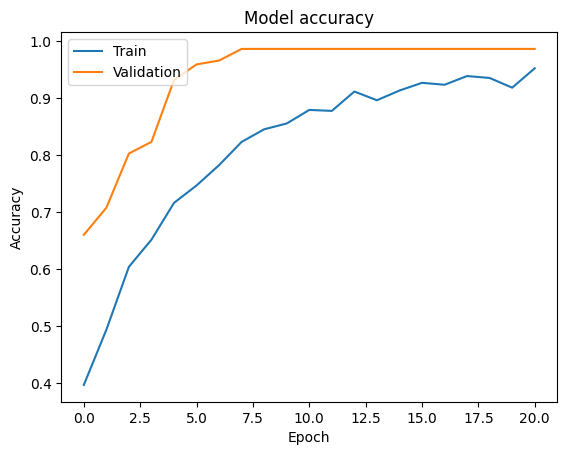

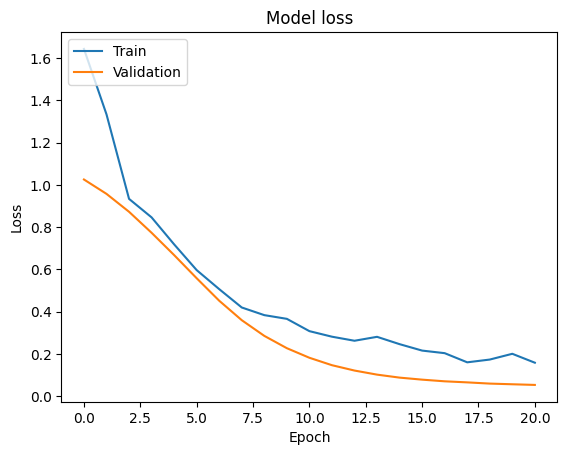

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [21]:
def predict_disease(symptoms_list):
    # Membuat vektor gejala untuk input
    input_vector = [0] * len(all_symptoms)
    valid_symptoms_found = False
    for symptom in symptoms_list:
        if symptom in all_symptoms:
            input_vector[all_symptoms.index(symptom)] = 1
            valid_symptoms_found = True

    if not valid_symptoms_found:
        print("Tidak ada gejala yang valid ditemukan dalam daftar input.")
        return None, None

    # Mengubah ke format yang sesuai untuk model (numpy array dan reshape)
    input_array = np.array([input_vector])

    # Melakukan prediksi
    prediction = model.predict(input_array)

    # Mendapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(prediction)

    # Mendapatkan nama penyakit dari LabelEncoder
    predicted_disease = le.inverse_transform([predicted_class_index])[0]

    return predicted_disease

# input dari user
user_input = input("Masukkan gejala (pisahkan dengan koma): ")
symptoms_to_predict = [sym.strip() for sym in user_input.split(",")]

predicted_disease = predict_disease(symptoms_to_predict)

if predicted_disease:
    print(f"Penyakit yang diprediksi: {predicted_disease}")

Masukkan gejala (pisahkan dengan koma): vomiting, dehydration, diarrhoea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Penyakit yang diprediksi: Gastroenteritis


In [22]:
import joblib
# Save symptoms to JSON file
with open('digestive_symptoms.json', 'w') as f:
    json.dump(all_symptoms, f, indent=4)
print("Symptoms saved to digestive_symptoms.json")

# Save model
model.save("digestive_disease_model.h5")
print("Model saved to digestive_disease_model.h5")

# Save LabelEncoder
joblib.dump(le, "digestive_label_encoder.pkl")
print("LabelEncoder saved to digestive_label_encoder.pkl")

Symptoms saved to digestive_symptoms.json
Model saved to digestive_disease_model.h5
LabelEncoder saved to digestive_label_encoder.pkl
